# Test spectral initialization 
- generate data 
- use spectral initialization to get embedding
- compare the embedding with real value 

In [ ]:
import sys 
sys.path.append('../')
from src_simulate_data.sim_data import Simulated 
import matplotlib.pyplot as plt 
from dlim.dataset import Data_model
from dlim.model import DLIM
import pandas as pd 
from numpy import linspace, arange, meshgrid, array, exp, sin, concatenate, cos
from numpy import pi as npi, power, diag, allclose
from numpy.linalg import det, svd, eig
from numpy.random import normal, uniform
import numpy as np

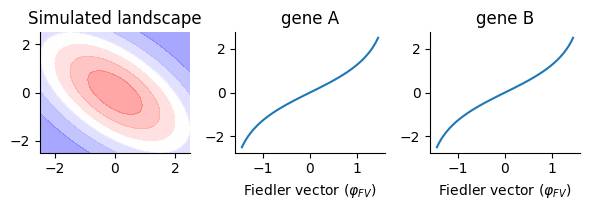

In [ ]:

# get gaussian landscape 
def rotated_gaussian_mesh(X, Y, alpha=45, center=[2.5, 2.5]):
    a = (3.14/180) * alpha
    m11 = cos(a)**2 / 2 + 2 * sin(a)**2
    m12_m21 = -sin(2*a) / 4 + sin(2*a)
    m22 = sin(a)**2 / 2 + 2 * cos(a)**2
    M = array([[m11, m12_m21],
               [m12_m21, m22]])
    det_M = det(M)
    X = X - center[0]
    Y = Y - center[0]

    F = exp(-((X**2 * M[0,0] + 2 * X * Y * M[0,1] + Y**2 * M[1,1]) / (2 * npi * det_M)))
    return F

nb_var = 40
A = linspace(-2.5, 2.5, 40)
B = linspace(-2.5, 2.5, 40)
p1, p2 = meshgrid(A, B)
land = rotated_gaussian_mesh(p1, p2, center=[0, 0])



fig, ax = plt.subplots(1, 3, figsize=(6, 2.2))
# Get original landscape 
ax[0].contourf(p1, p2, land, cmap="bwr", alpha=0.4)
ax[0].set_title("Simulated landscape")


# get similarity between mutations 
def cosine_similarity_matrix(A, pearson=False):
    if pearson:
        A = A - A.mean(axis=1, keepdims=True)
    # Step 1: Compute the dot product between all pairs of rows
    dot_product = np.dot(A, A.T)  # Shape: (N, N)
    # Step 2: Compute the L2 norms of each row
    norms = np.linalg.norm(A, axis=1)  # Shape: (N,)
    # Step 3: Compute the outer product of the norms
    norm_matrix = np.outer(norms, norms)  # Shape: (N, N)
    # Step 4: Compute the cosine similarity matrix
    cosine_similarity = dot_product / norm_matrix  # Element-wise division
    return cosine_similarity + 1

pearson = True
# get similarity between mutations on gene A
A_d = cosine_similarity_matrix(land, pearson=pearson)
D_is = np.diag(1.0 / np.sqrt(A_d.sum(axis=1)))
L_aa = np.eye(A_d.shape[0]) - D_is @ A_d @ D_is

# get similarity between mutations on gene B
A_d = cosine_similarity_matrix(land.T, pearson=pearson)
D_is = np.diag(1.0 / np.sqrt(A_d.sum(axis=1)))
L_bb = np.eye(A_d.shape[0]) - D_is @ A_d @ D_is

eiv_aa, eig_aa = eig(L_aa)
eiv_bb, eig_bb = eig(L_bb)
fid_aa = (eig_aa[:, 1] - eig_aa[:, -1].mean())/eig_aa[:, -1].std()
fid_bb = (eig_bb[:, 1] - eig_bb[:, -1].mean())/eig_bb[:, -1].std()

ax[1].plot(fid_aa.flatten(), A.flatten())
# ax[2].scatter(fid_bb.flatten(), A.flatten())
ax[1].set_title("gene A")
ax[1].set_xlabel("Fiedler vector ($\\varphi_{FV}$)")


ax[2].plot(fid_bb.flatten(), B.flatten())

# ax[2].scatter(fid_bb.flatten(), A.flatten())
ax[2].set_title("gene B")
ax[2].set_xlabel("Fiedler vector ($\\varphi_{FV}$)")
# ax[2].set_ylabel("True phenotype ($\\phi$)")

for i in range(3):
    for el in ["top", "right"]:
        ax[i].spines[el].set_visible(False)

plt.tight_layout()
plt.show()

## Step1: generate data 

In [34]:
type_f = "tgaus" 
nb_var = 30
n_variables  = 2 
data_simulated = Simulated(nb_var, type_f)
data = Data_model(data=pd.DataFrame(data_simulated.data), n_variables=n_variables)


/tmp/ipykernel_296410/2593899163.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


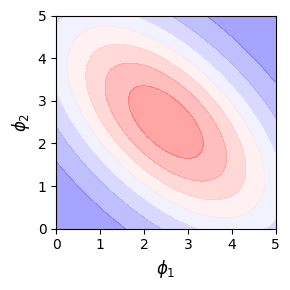

In [35]:
fig ,axe = plt.subplots(1, figsize = (3, 3))
data_simulated.plot(axe)
fig.tight_layout()
fig.show()

# Get spectral initialization 

In [38]:

model = DLIM(n_variables = data.nb_val, hid_dim = 32, nb_layer = 0)
# use pearson spectral initialization 
model.spec_init_emb(data, sim = 'pearson')
spectral_emb = model.genes_emb

spectral gap = 0.5793020725250244
spectral gap = 0.4568006992340088


# Plot the real value vs the value after spectral initialization 

/tmp/ipykernel_296410/2713725638.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


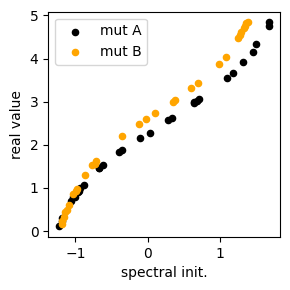

In [46]:
fig ,axe = plt.subplots(1, figsize = (3, 3))
axe.scatter(spectral_emb[0].detach(), data_simulated.A, c="black", s=20, label = 'mut A')
axe.scatter(spectral_emb[1].detach(), data_simulated.B, c="orange", s=20, label = 'mut B')
axe.set_xlabel('spectral init.')
axe.set_ylabel('real value')
plt.legend(loc = "best")
fig.tight_layout()
fig.show()